## Cell type deconvolution using MacSGP

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [2]:
RAW_PATH = "/import/home2/share/yqzeng/data/kidney_cancer/Mapping single cell transcriptomes in kidney cancer" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/kidney_cancer" # Deconvolution results
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

In [3]:
donor_id = "PD47171"

In [4]:
# scRNA-seq reference data
adata_ref = ad.read_h5ad(os.path.join(RAW_PATH, 'RCC_upload_final_raw_counts.h5ad'))
adata_ref = adata_ref[adata_ref.obs["patient"] == donor_id]

In [5]:
# ST data
adata_st = ad.read_h5ad(os.path.join(RAW_PATH, "visium_merge_inter_upload.h5ad"))
adata_st = adata_st[adata_st.obs["donor_id"] == donor_id]
adata_st.uns["spatial"] = {'spaceranger130_count_44214_6800STDY12499411_GRCh38-2020-A': adata_st.uns["spatial"]['spaceranger130_count_44214_6800STDY12499411_GRCh38-2020-A']}
adata_st.var_names = list(adata_st.var['SYMBOL'])
adata_st.var_names_make_unique()

In [ ]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 13808 edges, 2048 spots.
6.7421875 neighbors per spot on average.


In [7]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "broad_type",
                                                n_hvg_group = 500)

Finding highly variable genes...
3988 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [8]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 14/10000 [00:00<04:17, 38.80it/s]

Step: 0, Loss: -4086.4998, d_loss: -4092.3206, f_loss: 58.2077


 10%|█         | 1015/10000 [00:08<01:13, 122.38it/s]

Step: 1000, Loss: -5815.8647, d_loss: -5818.7285, f_loss: 28.6365


 20%|██        | 2016/10000 [00:16<01:05, 121.05it/s]

Step: 2000, Loss: -5872.0889, d_loss: -5874.9160, f_loss: 28.2719


 30%|███       | 3017/10000 [00:25<00:57, 121.56it/s]

Step: 3000, Loss: -5886.4351, d_loss: -5889.2314, f_loss: 27.9625


 40%|████      | 4018/10000 [00:33<00:49, 120.69it/s]

Step: 4000, Loss: -5893.6104, d_loss: -5896.3701, f_loss: 27.6001


 50%|█████     | 5019/10000 [00:41<00:41, 120.99it/s]

Step: 5000, Loss: -5898.3369, d_loss: -5901.0674, f_loss: 27.3055


 60%|██████    | 6020/10000 [00:49<00:32, 121.43it/s]

Step: 6000, Loss: -5900.0820, d_loss: -5902.7920, f_loss: 27.1006


 70%|███████   | 7021/10000 [00:57<00:24, 121.37it/s]

Step: 7000, Loss: -5900.8813, d_loss: -5903.5674, f_loss: 26.8621


 80%|████████  | 8022/10000 [01:06<00:16, 121.69it/s]

Step: 8000, Loss: -5901.0874, d_loss: -5903.7539, f_loss: 26.6666


 90%|█████████ | 9023/10000 [01:14<00:08, 121.45it/s]

Step: 9000, Loss: -5901.0923, d_loss: -5903.7466, f_loss: 26.5419


100%|██████████| 10000/10000 [01:22<00:00, 121.44it/s]


In [11]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "visium_1.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "visium_1_basis.h5ad"))

Dropping cell types: []


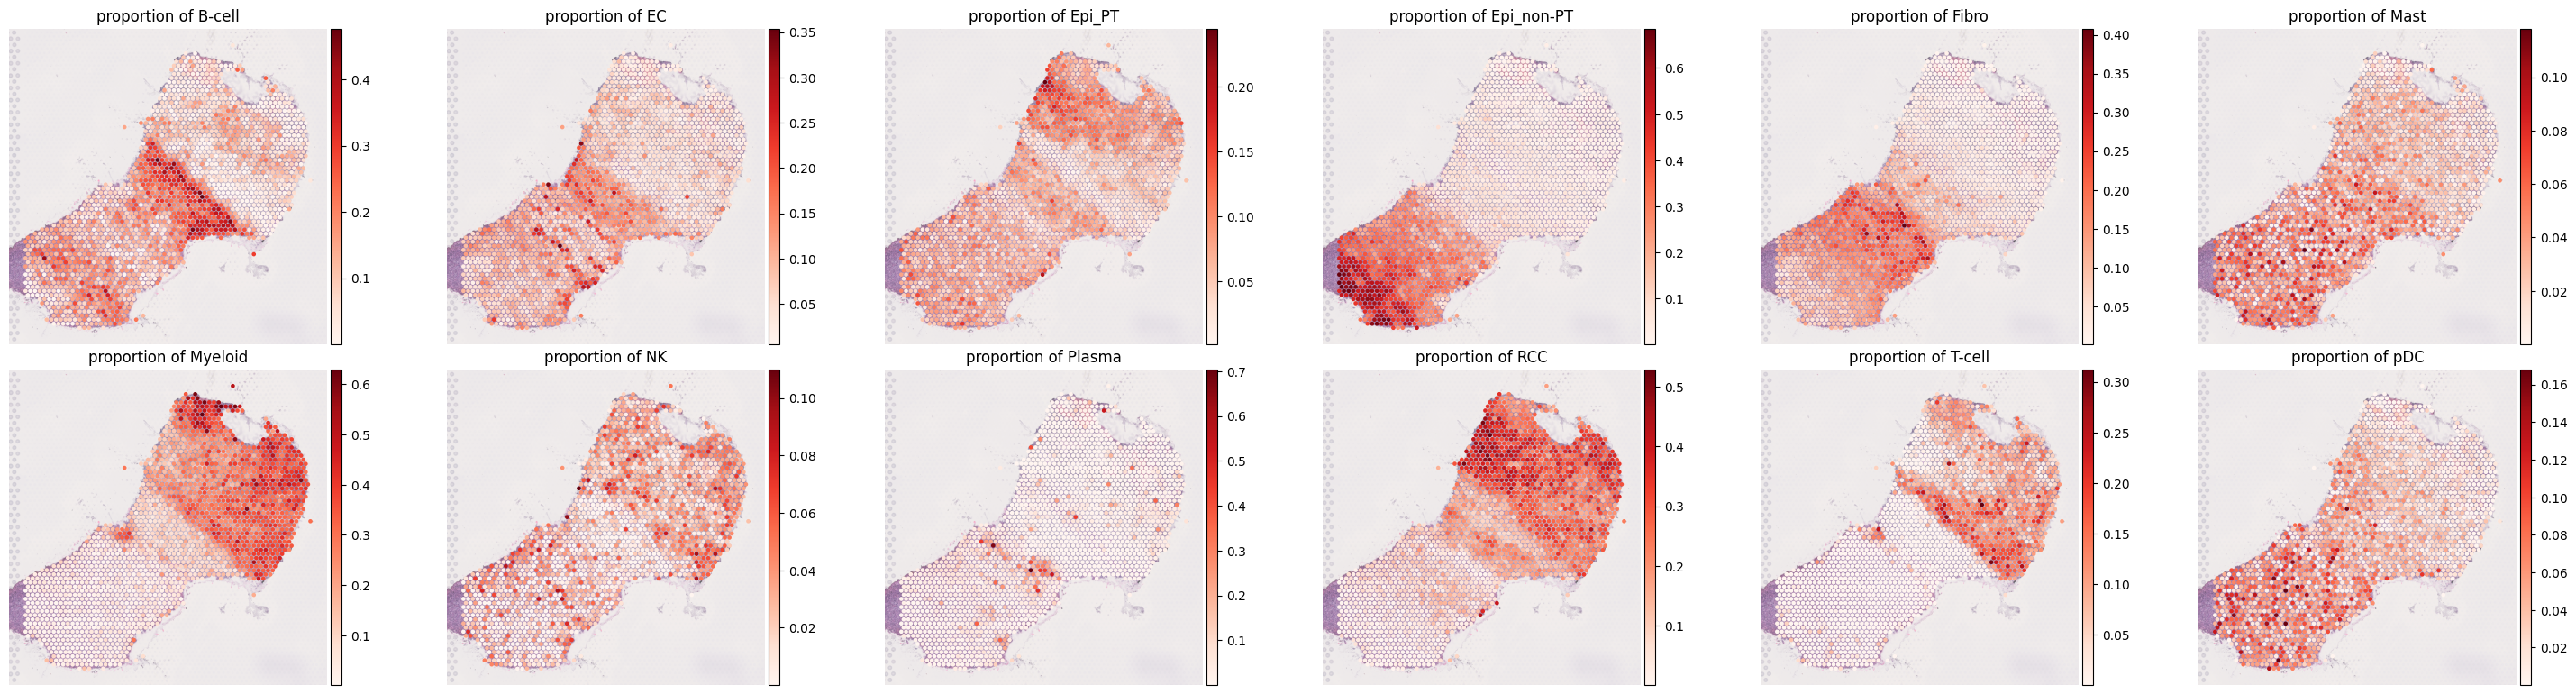

In [10]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.0, num_threshold=100, 
                cmap='Reds', 
                spot_size=100, 
                ncols=6)